In [1]:
import torch
from encoder.wormhole_encoder import WormholeEncoder
from generator.wormhole import WormholeGenerator
from datasets.distribution_datasets import NormalDistributionDataset
from torch.utils.data import DataLoader
from generator.losses import pairwise_sinkhorn, sink_D_batched

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

torch.autograd.set_detect_anomaly(True)

In [2]:
set_size = 100
dataset = NormalDistributionDataset(n_sets=10**5, data_shape=(2,), set_size=set_size)
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
)

In [3]:
in_dim = 2
latent_dim = 16
hidden_dim = 128
device = 'cuda'

enc = WormholeEncoder((2), latent_dim, hidden_dim, set_size)
gen = WormholeGenerator(latent_dim, (2), hidden_dim, set_size)
optimizer = torch.optim.Adam(list(enc.parameters()) + list(gen.parameters()), lr=1e-4)
enc.to(device)
gen.to(device);

In [4]:
for idx,batch in enumerate(dataloader):
    
    samples = batch['samples'].flatten(start_dim=2).to(device)
    latent = enc(samples)
    loss = gen.loss(samples.view(-1, *samples.shape[2:]), latent)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if idx % 100 == 0:
        print(idx, loss.item())

0 2.1344566345214844
100 0.6057026386260986
200 0.364021897315979
300 0.22412338852882385
400 0.43526768684387207
500 0.5451874732971191
600 0.11236639320850372
700 0.08223545551300049
800 0.537803590297699
900 0.06705755740404129
1000 0.5142452716827393
1100 0.08252542465925217


KeyboardInterrupt: 

In [5]:
enc.eval()
gen.eval()

n_points = 100


with torch.no_grad():
    samples = dataset.data[:n_points]
    mu, var = dataset.mu[:n_points], dataset.var[:n_points]
    W = dataset.wasserstein_distance(mu, var)

    samples = torch.tensor(samples, dtype=torch.float).to(device)
    latent = enc(samples.flatten(start_dim=2))

    L2 = torch.cdist(latent, latent)

    S2 = pairwise_sinkhorn(samples.flatten(start_dim=2))

Text(0, 0.5, 'Sinkhorn')

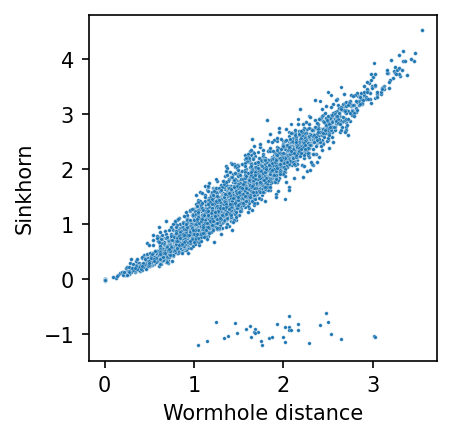

In [6]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=L2.flatten().cpu(), y=S2.flatten().cpu(), s=3)
plt.xlabel('Wormhole distance')
plt.ylabel('Sinkhorn')

Text(0, 0.5, 'Wasserstein distance')

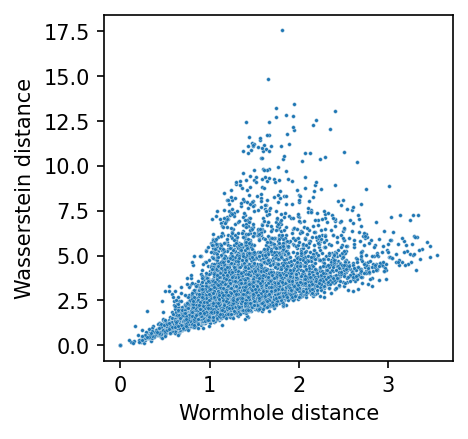

In [7]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=L2.flatten().cpu(), y=W.flatten(), s=3)
plt.xlabel('Wormhole distance')
plt.ylabel('Wasserstein distance')

Text(0.5, 0, 'Wasserstein distance')

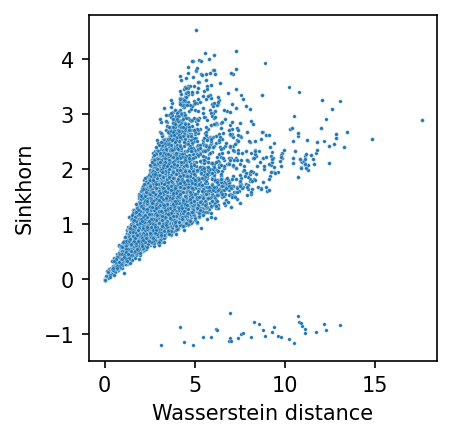

In [8]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=W.flatten(), y=S2.flatten().cpu(), s=3)
plt.ylabel('Sinkhorn')
plt.xlabel('Wasserstein distance')